# Make your own model
This notebook is used as a showcase of the basic functionality of nlmod. It downloads data, runs a groundwater model and visualizes some of the in- and output. Feel free to change some of the input-variables, for example the model domain (extent) or the simulation period (time).

This notebook builds a model using open data in the Netherlands. The parameters of the model are not calibrated in any way. Therefore, the model probably does not resemble reality very well.

In [2]:
# imports
from packaging.version import Version
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import flopy
import nlmod
import geopandas as gpd

In [3]:
# do a version check first
logger = nlmod.util.get_color_logger("INFO")

logger.info(f'Current version of nlmod is {nlmod.__version__}')
if not Version(nlmod.__version__) >= Version('0.5.2'):
    logger.warning('This notebook was made for nlmod version 0.5.2. Please update nlmod first.')

INFO:root:Current version of nlmod is 0.6.0


In [4]:
# basic setting

# set extent: [xmin, xmax, ymin, ymax]
# extent = [148_000, 149_000, 393_000, 394_000]  # somewhere in Noord-Brabant
# extent = [94_500, 96_500, 484_000, 485_000]  # somewhere along the coast
# extent = [120_000, 122_000, 486_000, 488_000]  # the centre of Amsterdam
# extent = [100_000, 101_000, 370_000, 371_000]  # in Belgium (needs to give Exception)
extent = [107_850, 111_750, 537_550, 542_050]  # somewhere in Zeeuws-Vlaanderen

dx = extent[1] - extent[0]
dy = extent[3] - extent[2]
# if dx > 2000 or dy > 2000:
#     msg = f"Model size is {dx} by {dy} meter. Please choose a smaller extent, as you will overload this workshop"
#     raise (Exception(msg))

## Download MODFLOW executables
nlmod does not contain the MODFLOW executable. We need to download the latest executable to the bin-directory of nlmod, if we run a model with nlmod for the first time.

In [5]:
if not nlmod.util.check_presence_mfbinaries():
    nlmod.util.download_mfbinaries()

## Download data
We download data from the internet about REGIS, the digintal terrain model (ahn), Basisregistratie Grootschalige Topografie (bgt) and data of the water boards: level areas (la) and watercourses (wc).

In [9]:
logger.info("Downloading data")
regis = nlmod.read.get_regis(extent)

ahn = nlmod.read.ahn.get_ahn4(extent)

bgt = nlmod.read.bgt.get_bgt(extent)

#la = nlmod.gwf.download_level_areas(bgt, extent=extent, raise_exceptions=False)


wc = nlmod.gwf.download_watercourses(bgt, extent=extent, raise_exceptions=False)

In [25]:
la_new = pd.read_csv('new_areas.csv', index_col='CODE')
new_la_df = gpd.geoseries.from_wkt(la_new.WKT.values)
la_new['geometry'] = new_la_df
la_new.drop(['WKT', 'fid'], axis=1, inplace=True)


la_new = {'Hollands Noorderkwartier': la_new}


In [28]:
la_new.geometry

AttributeError: 'dict' object has no attribute 'geometry'

## Combine surface water data
We combine the polygon-data of the Basisregistratie Grootschalige Topografie (BGT) with data about the surface level height (ahn) and data of the water boards: level areas (la) and watercourses (wc). We determine a stage and a bottom height (rbot) for ewach of the polygons.

In [27]:
# add information from ahn to bgt
bgt = nlmod.gwf.surface_water.add_min_ahn_to_gdf(bgt, ahn, buffer=5.0)

# add information from level areas (la) to bgt
bgt = nlmod.gwf.surface_water.add_stages_from_waterboards(bgt, la_new)

# add information from watercources (wc) to bgt
bgt = nlmod.gwf.surface_water.add_bottom_height_from_waterboards(bgt, wc)

# determine stage and rbot of surface water
bgt["stage"] = bgt[["winter_stage", "summer_stage"]].mean(1)
# set a mean sea level of 0.0 m NAP (when sea is in the model)
bgt.loc[bgt["class"] == "zee", "stage"] = 0.0
# when no stage is defined, set the stage to the minimum surface height
mask = bgt["stage"].isna()
bgt.loc[mask, "stage"] = bgt.loc[mask, "ahn_min"]

# rbot determines in which layer the drain is added
bgt["rbot"] = bgt["bottom_height"]
# when stage is below rbot, increase stage to rbot
mask = bgt["stage"] < bgt["rbot"]
bgt.loc[mask, "stage"] = bgt.loc[mask, "rbot"]
# when no bottom height is known, assume a water depth of 0,5 meter
mask = bgt["rbot"].isna()
bgt.loc[mask, "rbot"] = bgt.loc[mask, "stage"] - 0.5

Adding ['summer_stage', 'winter_stage'] from Hollands Noorderkwartier:   0%|          | 1/755 [00:00<00:00, 990.39it/s]


AttributeError: 'Series' object has no attribute 'intersection'

## Plot some input-data

In [ ]:
# plot a map with surface water bodies
f, ax = nlmod.plot.get_map(extent)
qm = nlmod.plot.data_array(ahn, ax=ax)
nlmod.plot.colorbar_inside(qm, label="Maaiveldhoogte volgens AHN4 (m NAP)")
handles = []
bgt.plot(ax=ax, color="k")
handles.append(matplotlib.patches.Patch(facecolor="k", label="BGT-laag waterdeel"))
for wb in wc:
    wc[wb].plot(ax=ax, color="b", linewidth=1)
    label = f"Data waterlopen {wb}"
    handles.append(matplotlib.lines.Line2D([], [], color="b", linewidth=1, label=label))
ax.legend(handles=handles, loc=2);

In [ ]:
# plot a cross-section through regis
f, ax = plt.subplots(figsize=(10, 5))
ax.set_xlabel('Afstand langs doorsnede (m)')
ax.set_ylabel('z (m NAP)')
# define a line from southwest to northeast
sw = (extent[0], extent[2])
ne = (extent[1], extent[3])
line = [sw, ne]
dcs = nlmod.plot.dcs.DatasetCrossSection(regis, line, zmin=-200, zmax=float(ahn.max()))
dcs.plot_layers(nlmod.read.regis.get_legend(), min_label_area=10000)
f.tight_layout(pad=0.0)

## Start a model Dataset
We add most of the grid-data to a model Dataset, which is an xarray Dataset. We add grid-refinement (opionally), change the model top and download KNMI-data.

In [30]:
model_name = "nhv_dag"
model_ws = os.path.join("model", model_name)
ds = nlmod.to_model_ds(regis, delr=50, model_name=model_name, model_ws=model_ws)

if True:
    # refine model
    ds = nlmod.grid.refine(ds, refinement_features=[(bgt, 1)])

if True:
    # calculate a finer top from ahn
    top = nlmod.resample.structured_da_to_ds(ahn, ds)
    # when top is NaN, keep the original top
    top = top.where(~top.isnull(), ds["top"])
    # set the new top
    ds = nlmod.layers.set_model_top(ds, top)

if False:
    # set starting head to surface level (instead of 0.0)
    strt = np.repeat(ds["top"].data[np.newaxis, :], len(ds.layer), 0)
    ds["starting_head"] = ds["botm"].dims, strt

# set time dimension
time = pd.date_range("2017", "2023", freq="SMS")
ds = nlmod.time.set_ds_time(ds, time)

# download knmi-data to determine recharge
ds.update(nlmod.read.knmi.get_recharge(ds, cachedir=ds.cachedir, cachename="knmi.nc"))

INFO:nlmod.dims.base:resample layer model data to structured modelgrid
INFO:nlmod.dims.layers:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers:Filling 41386 values in active cells of kh by multipying kv by an anisotropy of 10
INFO:nlmod.dims.layers:Filling 150065 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers:Filling 7020 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers:Filling 7020 values in active cells of kv with a value of 0.1 m/day
INFO:nlmod.dims.grid:create vertex grid using gridgen
INFO:nlmod.dims.grid:resample model Dataset to vertex modelgrid
INFO:nlmod.dims.resample:No crs in ds. Setting crs equal to da: EPSG:28992
INFO:hydropandas.io.knmi:last RD measurement available at the Bilt is from 2023-05-20
INFO:hydropandas.io.knmi:assuming no RD measurements are available at other stations after this date
INFO:hydropandas.io.knmi:changing end_date to 2023-01-01
INFO:hydropandas.io.knmi:download knmi

<xarray.Dataset>
Dimensions:   (icell2d: 18942, layer: 36, iv: 21101, icv: 9, time: 145)
Coordinates:
  * layer     (layer) <U64 'HLc' 'BXz2' 'BXk1' 'BXz3' ... 'OOz2' 'OOc' 'BRk1'
    x         (icell2d) float64 1.079e+05 1.079e+05 ... 1.117e+05 1.117e+05
    y         (icell2d) float64 5.42e+05 5.42e+05 ... 5.376e+05 5.376e+05
  * time      (time) datetime64[ns] 2017-01-01 2017-01-15 ... 2023-01-01
Dimensions without coordinates: icell2d, iv, icv
Data variables:
    top       (icell2d) float64 -1.0 -1.0 -1.0 -1.0 ... 1.123 1.306 1.432 0.8589
    botm      (layer, icell2d) float64 -8.12 -8.12 -8.12 ... -711.5 -711.5
    kh        (layer, icell2d) float32 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02 0.02
    kv        (layer, icell2d) float32 0.1 0.1 0.1 0.1 ... 0.002 0.002 0.002
    idomain   (layer, icell2d) int32 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    area      (icell2d) float32 625.0 625.0 625.0 625.0 ... 625.0 625.0 625.0
    xv        (iv) float64 1.078e+05 1.079e+05 1.079e+05 ... 1.117e+05 1.118e+05
    yv        (iv) float64 5.42e+05 5.42e+05 5.42e+05 ... 5.376e+05 5.376e+05
    icvert    (icell2d, icv) int32 0 1 2 3 0 -1 -1 ... 21099 21097 -1 -1 -1 -1
    recharge  (time, icell2d) float64 0.0005226 0.0005226 ... 0.003453 0.003453
Attributes:
    extent:                    [107850, 111750, 537550, 542050]
    gridtype:                  vertex
    delr:                      50
    delc:                      50
    model_name:                nhv_dag
    mfversion:                 mf6
    model_dataset_created_on:  20230613_09:20:24
    exe_name:                  C:\Users\anne-\anaconda3\envs\envm1602_groundw...
    model_ws:                  model\nhv_dag
    figdir:                    model\nhv_dag\figure
    cachedir:                  model\nhv_dag\cache
    transport:                 0

## Make a groundwater flow model (gwf)
For FloPy, we create a simulation (sim) and a groundwater flow model (gwf) usinge the method  `nlmod.gwf.ds_to_gwf()`. It adds the basic MODFLOW packages to the simulation (tdis and ims) and the groundwater flow model (dis, npf, ic, oc). If "recharge" is present in DataSet, its add a rch-package as well.

In [31]:
gwf = nlmod.gwf.ds_to_gwf(ds, complexity="moderate", icelltype=0, under_relaxation=False)

# add storage package
sy = 0.2
ss = 1e-05
ss_confined_only = True
if ss_confined_only:
    # use a trick to calculate with a storage coefficient of 1.0 (surface water)
    # when the top layer is fully saturated
    ss = xr.full_like(ds["idomain"], 1e-05, float)
    fal = nlmod.layers.get_first_active_layer(ds)
    ss[fal] = 1.0 / nlmod.layers.calculate_thickness(ds)[fal]
nlmod.gwf.sto(ds, gwf, sy=sy, ss=ss, ss_confined_only=ss_confined_only);

INFO:nlmod.sim.sim:creating modflow SIM
INFO:nlmod.sim.sim:creating modflow TDIS
INFO:nlmod.sim.sim:creating modflow IMS
INFO:nlmod.gwf.gwf:creating modflow GWF
INFO:nlmod.gwf.gwf:creating modflow DISV
INFO:nlmod.gwf.gwf:creating modflow NPF
INFO:nlmod.gwf.gwf:creating modflow IC
INFO:nlmod.gwf.gwf:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf:creating modflow OC
INFO:nlmod.gwf.gwf:creating modflow RCH


Building ts packages rch: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.33it/s]


INFO:nlmod.gwf.gwf:creating modflow STO
INFO:nlmod.util:Using user-provided 'ss' and not stored data variable 'ds.idomain'


In [32]:
# split surface water by modelgrid
bgt_grid = nlmod.grid.gdf_to_grid(bgt, ds).set_index("cellid")
# calculate conductance from a resistance of 1.0 days
bgt_grid["cond"] = bgt_grid.area / 1.0

# add surface water as drains
spd = nlmod.gwf.surface_water.build_spd(bgt_grid, "DRN", ds)
flopy.mf6.ModflowGwfdrn(gwf, stress_period_data={0: spd});

Building stress period data DRN: 100%|█████████████████████████████████████████| 12019/12019 [00:03<00:00, 3546.44it/s]


## Run model
We write input-files for MODFLOW 6 and run the model.

In [33]:
nlmod.sim.write_and_run(gwf, ds)

INFO:nlmod.sim.sim:write model dataset to cache
INFO:nlmod.sim.sim:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model nhv_dag...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package rch...
    writing package ts_0...
    writing package sto...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 12019 based on size of stress_period_data
INFO:nlmod.sim.sim:run model
FloPy is using the following executable to run the model: C:\Users\anne-\anaconda3\envs\envm1602_groundwater\Lib\site-packages\nlmod\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                        VERSION 6.4.1 Release 12/09/2022

   MODFLOW 6 compiled Apr 12 2023 19:05:25 with

## Plot some output-data

In [38]:
# read heads and determine gxg
head = nlmod.gwf.get_heads_da(ds)
gxg = nlmod.gwf.calculate_gxg(head)

In [116]:
# note how selecting one variable allowed for multiple time steps in a single raster



#ds.heads.rio.to_raster("head_low.tif")


ds_hlc = ds.heads[:, 0]
#ds_hlc.rio.to_raster("head_low.tif")

gxg

<xarray.Dataset>
Dimensions:      (layer: 36, icell2d: 18942)
Coordinates:
  * layer        (layer) <U64 'HLc' 'BXz2' 'BXk1' 'BXz3' ... 'OOz2' 'OOc' 'BRk1'
    spatial_ref  int32 0
Dimensions without coordinates: icell2d
Data variables:
    gvg          (layer, icell2d) float64 -0.09939 -0.09941 ... -0.4333 -0.4333
    glg          (layer, icell2d) float64 -0.4608 -0.4608 ... -0.6404 -0.6404
    ghg          (layer, icell2d) float64 -0.03733 -0.03736 ... -0.3769 -0.3769
    n_years_gvg  (layer, icell2d) int32 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6
    n_years_gxg  (layer, icell2d) int32 5 5 5 5 5 5 5 5 5 ... 5 5 5 5 5 5 5 5 5

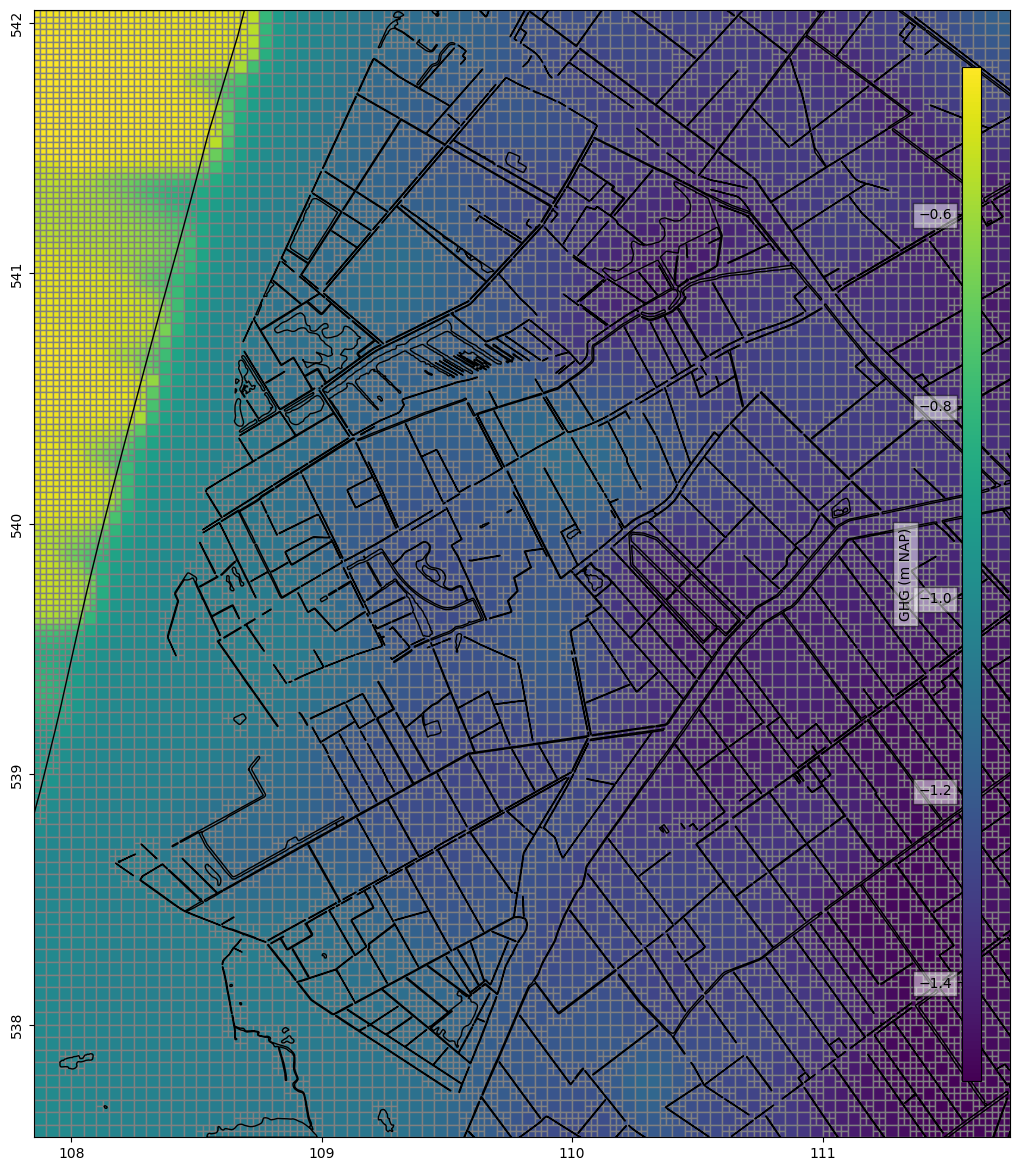

In [117]:
# plot ghg of the first active layer
f, ax = nlmod.plot.get_map(extent)
fal = nlmod.layers.get_first_active_layer(ds)
qm = nlmod.plot.data_array(gxg["glg"][fal], ds=ds, edgecolor="grey")
bgt.plot(ax=ax, linewidth=1, edgecolor="k", facecolor="none")
nlmod.plot.colorbar_inside(qm, label="GHG (m NAP)");

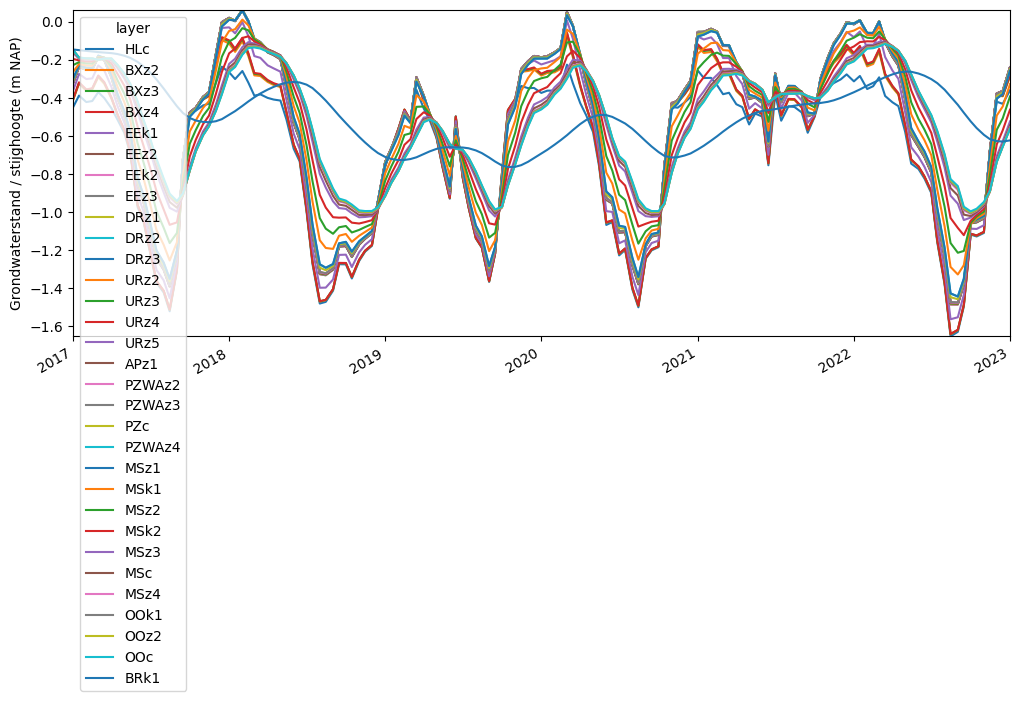

In [40]:
# plot the head at a certain point in several layers
x = np.mean([extent[0], extent[1]])
y = np.mean([extent[2], extent[3]])
head_point = nlmod.gwf.get_head_at_point(head, x, y, ds=ds)
f, ax = plt.subplots(figsize=(10, 6))
head_point.to_pandas().plot(ax=ax)
ax.autoscale(tight=True)
ax.set_ylabel('Grondwaterstand / stijghoogte (m NAP)')
ax.set_xlabel('')
f.tight_layout(pad=0.0)

## Compare with measurements

In [41]:
# download measurements
import hydropandas as hpd

fname_pklz = os.path.join(ds.cachedir, 'oc_bro.pklz')
if os.path.exists(fname_pklz):
    oc = pd.read_pickle(fname_pklz)
else:
    oc = hpd.read_bro(extent=ds.extent, name='BRO', tmin=ds.time.values.min(), tmax=ds.time.values.max(), )
    oc.to_pickle(fname_pklz)


# get modellayers
oc['modellayer'] = oc.gwobs.get_modellayers(ds=ds)

# get modelled head at measurement points
ds['heads'] = nlmod.gwf.get_heads_da(ds)
oc_modflow = hpd.read_modflow(oc, gwf, ds['heads'].values, ds.time.values)

# add modelled head to measured heads
obs_list_map = []
for gld in oc.index:
    o = oc.loc[gld,'obs']
    if o.empty:
        continue
    
    o = o.resample('D').last().sort_index()
    modelled = oc_modflow.loc[gld, 'obs']
    modelled = hpd.GroundwaterObs(modelled.rename(columns={0: 'values'}), name=f'{o.name}_mod_lay{oc.loc[gld,"modellayer"]}', x=o.x, y=o.y, 
                                  tube_nr=o.tube_nr+1,screen_top=o.screen_top, screen_bottom=o.screen_bottom, 
                                  tube_top=o.tube_top, monitoring_well=o.monitoring_well, source='MODFLOW', unit= 'm NAP',
                                  ground_level=o.ground_level, metadata_available=o.metadata_available)
    obs_list_map.append(o)
    obs_list_map.append(modelled)

oc_map = hpd.ObsCollection.from_list(obs_list_map, name='meting+model')

# c#create interactive map
oc_map.plots.interactive_map(os.path.join(ds.figdir, 'iplots'))

  0%|                                                                                           | 0/45 [00:00<?, ?it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000015224
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015224 and tube number 1


  2%|█▊                                                                                 | 1/45 [00:00<00:16,  2.75it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000015278
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015278 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000015278
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015278 and tube number 2
INFO:hydropandas.io.bro:reading bro_id GMW000000015278
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015278 and tube number 3


  4%|███▋                                                                               | 2/45 [00:01<00:34,  1.25it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000015282


  7%|█████▌                                                                             | 3/45 [00:02<00:33,  1.27it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000015357
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015357 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000015357
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015357 and tube number 2
INFO:hydropandas.io.bro:reading bro_id GMW000000015357
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015357 and tube number 3


  9%|███████▍                                                                           | 4/45 [00:03<00:34,  1.20it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000015491
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015491 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000015491
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015491 and tube number 2


 11%|█████████▏                                                                         | 5/45 [00:03<00:33,  1.19it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000015529
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015529 and tube number1
INFO:hydropandas.io.bro:reading bro_id GMW000000015529
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015529 and tube number2
INFO:hydropandas.io.bro:reading bro_id GMW000000015529
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000015529 and tube number3


 13%|███████████                                                                        | 6/45 [00:05<00:39,  1.02s/it]

INFO:hydropandas.io.bro:reading bro_id GMW000000033926
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000033926 and tube number 1


 16%|████████████▉                                                                      | 7/45 [00:05<00:30,  1.24it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000033973
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000033973 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000033973
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000033973 and tube number 2


 18%|██████████████▊                                                                    | 8/45 [00:06<00:27,  1.36it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000034038
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000034038 and tube number 1


 20%|████████████████▌                                                                  | 9/45 [00:06<00:21,  1.67it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000035222
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000035222 and tube number 1


 22%|██████████████████▏                                                               | 10/45 [00:06<00:17,  1.97it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067613
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067613 and tube number 1


 24%|████████████████████                                                              | 11/45 [00:07<00:15,  2.15it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067614
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067614 and tube number 1


 27%|█████████████████████▊                                                            | 12/45 [00:07<00:14,  2.23it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067615
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067615 and tube number 1


 29%|███████████████████████▋                                                          | 13/45 [00:08<00:13,  2.35it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067616
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067616 and tube number 1


 31%|█████████████████████████▌                                                        | 14/45 [00:08<00:12,  2.47it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067617
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067617 and tube number 1


 33%|███████████████████████████▎                                                      | 15/45 [00:08<00:11,  2.56it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067618
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067618 and tube number 1


 36%|█████████████████████████████▏                                                    | 16/45 [00:09<00:10,  2.76it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067619
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067619 and tube number 1


 38%|██████████████████████████████▉                                                   | 17/45 [00:09<00:09,  2.93it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067620
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067620 and tube number 1


 40%|████████████████████████████████▊                                                 | 18/45 [00:09<00:08,  3.09it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067621
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067621 and tube number 1


 42%|██████████████████████████████████▌                                               | 19/45 [00:09<00:08,  3.09it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067622
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067622 and tube number 1


 44%|████████████████████████████████████▍                                             | 20/45 [00:10<00:08,  2.98it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067623
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067623 and tube number 1


 47%|██████████████████████████████████████▎                                           | 21/45 [00:10<00:08,  2.94it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067624
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067624 and tube number 1


 49%|████████████████████████████████████████                                          | 22/45 [00:11<00:08,  2.59it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067625
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067625 and tube number 1


 51%|█████████████████████████████████████████▉                                        | 23/45 [00:11<00:08,  2.63it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067626
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067626 and tube number 1


 53%|███████████████████████████████████████████▋                                      | 24/45 [00:11<00:08,  2.58it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067627
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067627 and tube number 1


 56%|█████████████████████████████████████████████▌                                    | 25/45 [00:12<00:08,  2.39it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067628
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067628 and tube number 1


 58%|███████████████████████████████████████████████▍                                  | 26/45 [00:12<00:07,  2.41it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067629
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067629 and tube number 1


 60%|█████████████████████████████████████████████████▏                                | 27/45 [00:13<00:07,  2.50it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067630
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067630 and tube number 1


 62%|███████████████████████████████████████████████████                               | 28/45 [00:13<00:06,  2.71it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000067631
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000067631 and tube number 1


 64%|████████████████████████████████████████████████████▊                             | 29/45 [00:13<00:05,  2.72it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074863
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074863 and tube number 1


 67%|██████████████████████████████████████████████████████▋                           | 30/45 [00:14<00:05,  2.88it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074864
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074864 and tube number 1


 69%|████████████████████████████████████████████████████████▍                         | 31/45 [00:14<00:04,  2.81it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074865
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074865 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000074865
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074865 and tube number 2


 71%|██████████████████████████████████████████████████████████▎                       | 32/45 [00:15<00:05,  2.20it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074866
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074866 and tube number 1


 73%|████████████████████████████████████████████████████████████▏                     | 33/45 [00:15<00:05,  2.31it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074867
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074867 and tube number 1


 76%|█████████████████████████████████████████████████████████████▉                    | 34/45 [00:15<00:04,  2.45it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074868
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074868 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000074868
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074868 and tube number 2
INFO:hydropandas.io.bro:reading bro_id GMW000000074868
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074868 and tube number 3


 78%|███████████████████████████████████████████████████████████████▊                  | 35/45 [00:16<00:05,  1.74it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074870
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074870 and tube number 1
INFO:hydropandas.io.bro:reading bro_id GMW000000074870
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074870 and tube number 2
INFO:hydropandas.io.bro:reading bro_id GMW000000074870
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074870 and tube number 3


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [00:18<00:06,  1.38it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074872
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074872 and tube number 1


 82%|███████████████████████████████████████████████████████████████████▍              | 37/45 [00:18<00:04,  1.67it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074873
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074873 and tube number 1


 84%|█████████████████████████████████████████████████████████████████████▏            | 38/45 [00:18<00:03,  1.91it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074874
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074874 and tube number 1


 87%|███████████████████████████████████████████████████████████████████████           | 39/45 [00:18<00:02,  2.18it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074875
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074875 and tube number 1


 89%|████████████████████████████████████████████████████████████████████████▉         | 40/45 [00:19<00:02,  2.36it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074876
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074876 and tube number 1


 91%|██████████████████████████████████████████████████████████████████████████▋       | 41/45 [00:19<00:01,  2.57it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074884
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074884 and tube number 1


 93%|████████████████████████████████████████████████████████████████████████████▌     | 42/45 [00:19<00:01,  2.75it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074885
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074885 and tube number 1


 96%|██████████████████████████████████████████████████████████████████████████████▎   | 43/45 [00:20<00:00,  2.78it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074886
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074886 and tube number 1


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 44/45 [00:20<00:00,  2.90it/s]

INFO:hydropandas.io.bro:reading bro_id GMW000000074887
INFO:hydropandas.io.bro:no groundwater level dossier for GMW000000074887 and tube number 1


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:20<00:00,  2.15it/s]


TypeError: could not infer observation type

#### Exercise 10

In the cells above change the extent to a place in the Netherlands you would like to model. Run the model and check the results. Try to see which processes are missing or modelled incorrectly. Think about how you can improve this.

Note: this functionality of nlmod has not been tested thoroughly so there is a big chance you will encounter errors that are hard to solve, sorry for that :)

In [44]:
obs_list_map

[]

In [65]:
pd.read_pickle(fname_pklz)

,x,y,filename,source,unit,monitoring_well,tube_nr,screen_top,screen_bottom,ground_level,tube_top,metadata_available,obs
name,,,,,,,,,,,,,
GMW000000015224_1,108232.0,537759.0,,BRO,m NAP,GMW000000015224,1,2.11,1.11,3.17,3.13,True,GroundwaterObs GMW000000015224_1 -----metadata...
GMW000000015278_1,108787.0,538114.0,,BRO,m NAP,GMW000000015278,1,-1.31,-2.31,2.79,3.54,True,GroundwaterObs GMW000000015278_1 -----metadata...
GMW000000015278_2,108787.0,538114.0,,BRO,m NAP,GMW000000015278,2,-12.21,-13.21,2.79,3.52,True,GroundwaterObs GMW000000015278_2 -----metadata...
GMW000000015278_3,108787.0,538114.0,,BRO,m NAP,GMW000000015278,3,-24.86,-25.86,2.79,3.50,True,GroundwaterObs GMW000000015278_3 -----metadata...
GMW000000015282_1,108301.0,537658.0,,BRO,m NAP,GMW000000015282,1,0.66,0.51,2.63,2.61,True,GroundwaterObs GMW000000015282_1 -----metadata...
GMW000000015357_1,109986.0,539781.0,,BRO,m NAP,GMW000000015357,1,-0.44,-1.44,1.08,1.00,True,GroundwaterObs GMW000000015357_1 -----metadata...
GMW000000015357_2,109986.0,539781.0,,BRO,m NAP,GMW000000015357,2,-10.93,-11.93,1.08,0.99,True,GroundwaterObs GMW000000015357_2 -----metadata...
GMW000000015357_3,109986.0,539781.0,,BRO,m NAP,GMW000000015357,3,-25.93,-26.93,1.08,0.97,True,GroundwaterObs GMW000000015357_3 -----metadata...
GMW000000015491_1,109668.0,538135.0,,BRO,m NAP,GMW000000015491,1,-0.18,-1.18,0.32,0.26,True,GroundwaterObs GMW000000015491_1 -----metadata...


'model\\nhv_dag\\cache\\oc_bro.pklz'